# Importing

In [1]:
import os
import random
from glob import glob
import glob
from PIL import Image
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import datasets, transforms
import torchvision

from tqdm import tqdm

import kagglehub
import imageio
import math
import re

In [2]:
# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/celeba-dataset


# Hyperparameters and Setup

In [27]:
# Hyperparameters etc
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
EPOCHS = 1 # just to show the result
NUM_COND = 1
ROOT_DIR = os.path.join(path, "/img_align_celeba/img_align_celeba")
NUM_WORKERS = 2
SEED = 42

cuda


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

In [5]:
def denorm(img_tensors, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return img_tensors * std + mean

# Custom Dataset

In [6]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None, max_samples=None, seed=None, selected_attributes=None):

        self.root_dir = root_dir
        self.transform = transform
        self.selected_attributes = selected_attributes

        # Load the attributes CSV
        attributes_path = os.path.join(root_dir, 'list_attr_celeba.csv')
        df = pd.read_csv(attributes_path)

        # Random sample the dataframe if max_samples is specified
        if max_samples:
            df = df.sample(n=max_samples, random_state=SEED).reset_index(drop=True)

        self.images_array = []
        self.attributes_array = []

        for idx, row in tqdm(df.iterrows(), total=len(df)):
            img_filename = row['image_id']
            img_path = os.path.join(root_dir,"img_align_celeba","img_align_celeba", img_filename)

            if os.path.exists(img_path):
                self.images_array.append(img_path)

                # Extract and convert selected attributes
                attribute = row[self.selected_attributes].values
                attribute = [(int(val) + 1) // 2 for val in attribute]  # Convert -1/1 to 0/1
                self.attributes_array.append(attribute)

    def __len__(self):
        return len(self.images_array)

    def __getitem__(self, idx):
        img_path = self.images_array[idx]
        attributes = torch.tensor(self.attributes_array[idx], dtype=torch.long)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, attributes


In [7]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1], and if it was gray scale make it like this ([0.5], [0.5])
])

In [8]:
Dataset = CelebADataset(
    root_dir=path,
    transform=train_transform,
    max_samples=40000,
    selected_attributes = ["Male"],
    seed=SEED
)

attributes = Dataset.selected_attributes

100%|██████████| 40000/40000 [00:37<00:00, 1079.66it/s]


In [9]:
dataloader = DataLoader(Dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
print(f"Total number of images loaded: {len(Dataset)}")
print(f"The attributes we select: {attributes}")

Total number of images loaded: 40000
The attributes we select: ['Male']


# Exploratory Analysis¶

In [10]:
df = pd.read_csv("/kaggle/input/celeba-dataset/list_attr_celeba.csv")
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


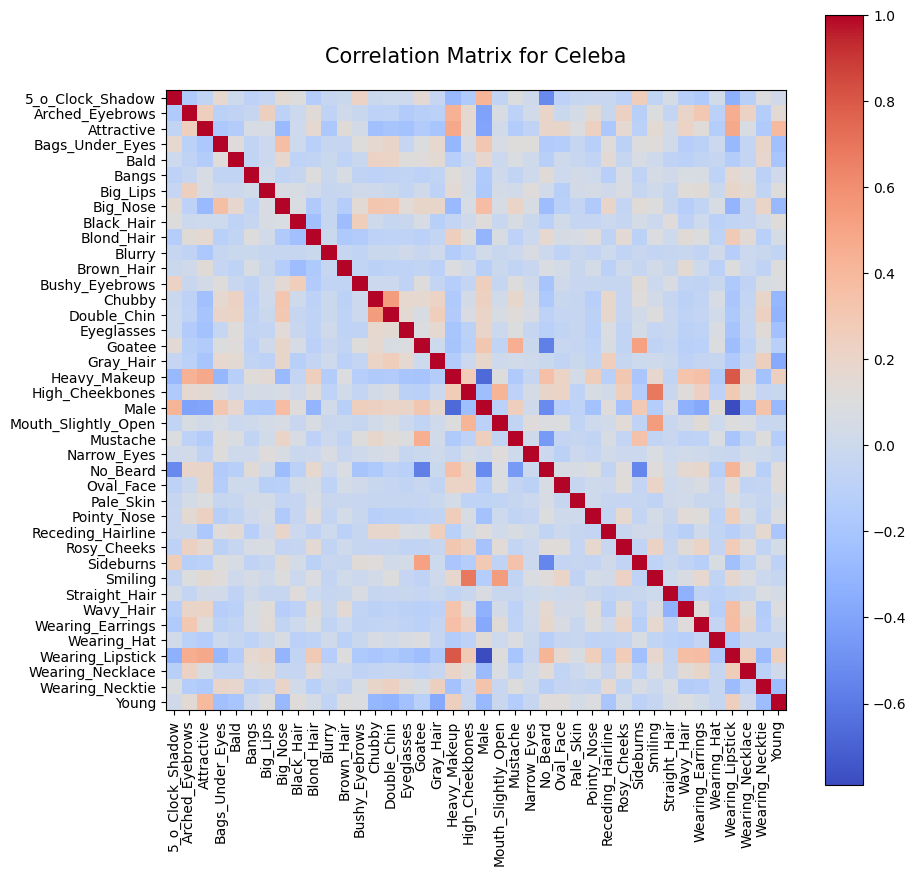

In [16]:
def plot_correlation_matrix(dataframe, graph_width=10):
    # Keep only numeric columns
    numeric_df = dataframe.select_dtypes(include=[np.number])
    # Drop columns with all NaN values
    numeric_df = numeric_df.dropna(axis=1)
    # Compute correlation matrix
    corr_matrix = numeric_df.corr()

    # Plot correlation matrix
    fig, ax = plt.subplots(figsize=(graph_width, graph_width))
    heatmap = ax.matshow(corr_matrix, cmap='coolwarm')
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    ax.xaxis.set_ticks_position('bottom')
    plt.colorbar(heatmap)
    plt.title('Correlation Matrix for Celeba', fontsize=15, pad=20)
    plt.show()
plot_correlation_matrix(df)

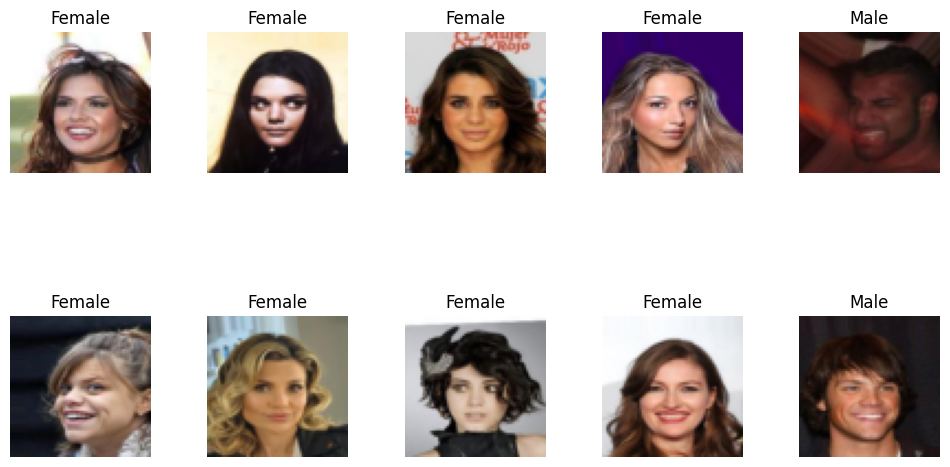

Shape of one image tensor: torch.Size([3, 64, 64])
Shape of a group of iamges is: torch.Size([128, 3, 64, 64])


In [17]:
# To display the images after the transforms
data_iter = iter(dataloader)
images, labels= next(data_iter)

def convert_attr(attr_tensor, attribute_names):
    values = attr_tensor.cpu().numpy().tolist()
    return ", ".join([name for name, val in zip(attribute_names, values) if val == 1]) or "Female"

# Show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
plt.subplots_adjust(hspace=0.6, wspace=0.4)
for i, ax in enumerate(axes.flat):
    img = images[i]
    # print(f" images before reshape {img.shape}")
    img = np.transpose(img.numpy(), (1, 2, 0))  # Convert (C, H, W) to (H, W, C)
    # print(f" images after reshape {img.shape}")
    img_display = (img + 1) / 2 # if it was normalize use this to recover it
    ax.imshow(img_display) # expects a numpy array
    # ax.set_title(f"Image {i}")
    ax.set_title(convert_attr(labels[i], attributes))
    ax.axis("off")
plt.show()

print("Shape of one image tensor:", images[0].shape)
print("Shape of a group of iamges is:", images.shape)

# Create the cDCGAN

In [18]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, num_attributes=1, attr_embedding_size=5, feature_dim=64):
        super(Generator, self).__init__()

        self.z_dim = z_dim
        self.num_attributes = num_attributes
        self.attr_embedding_size = attr_embedding_size
        self.feature_dim = feature_dim
        self.total_attr_embed = num_attributes * attr_embedding_size

        # Embedding layer for each attribute (binary classes: 0 or 1)
        self.attr_embeddings = nn.ModuleList([
            nn.Embedding(2, attr_embedding_size) for _ in range(num_attributes)
        ])

        # Process noise vector: z → (B, 256, 4, 4)
        self.deconv1_noise = nn.ConvTranspose2d(z_dim, feature_dim * 4, 4, 1, 0)     # (B, 100, 1, 1) → (B, 256, 4, 4)
        self.bn1_noise = nn.BatchNorm2d(feature_dim * 4)

        # Process embedded attribute: → (B, 256, 4, 4)
        self.deconv1_attr = nn.ConvTranspose2d(self.total_attr_embed, feature_dim * 4, 4, 1, 0)  # (B, 5, 1, 1) → (B, 256, 4, 4)
        self.bn1_attr = nn.BatchNorm2d(feature_dim * 4)

        # Upsampling path
        self.deconv2 = nn.ConvTranspose2d(feature_dim * 8, feature_dim * 4, 4, 2, 1)  # (B, 512, 4, 4) → (B, 256, 8, 8)
        self.bn2 = nn.BatchNorm2d(feature_dim * 4)

        self.deconv3 = nn.ConvTranspose2d(feature_dim * 4, feature_dim * 2, 4, 2, 1)  # (B, 256, 8, 8) → (B, 128, 16, 16)
        self.bn3 = nn.BatchNorm2d(feature_dim * 2)

        self.deconv4 = nn.ConvTranspose2d(feature_dim * 2, feature_dim, 4, 2, 1)      # (B, 128, 16, 16) → (B, 64, 32, 32)
        self.bn4 = nn.BatchNorm2d(feature_dim)

        self.deconv5 = nn.ConvTranspose2d(feature_dim, 3, 4, 2, 1)                    # (B, 64, 32, 32) → (B, 3, 64, 64)

    def forward(self, noise, attributes):
        # Convert attribute tensor to embeddings
        attributes = attributes.long()
        attr_embeds = [self.attr_embeddings[i](attributes[:, i]) for i in range(self.num_attributes)]  # list of (B, 5)
        attr_vector = torch.cat(attr_embeds, dim=1)  # (B, total_attr_embed)
        attr_vector = attr_vector.view(attr_vector.size(0), self.total_attr_embed, 1, 1)  # (B, E, 1, 1)

        # Process noise and attribute embeddings
        x = F.leaky_relu(self.bn1_noise(self.deconv1_noise(noise)), 0.2)  # (B, 256, 4, 4)
        y = F.leaky_relu(self.bn1_attr(self.deconv1_attr(attr_vector)), 0.2)  # (B, 256, 4, 4)

        # Concatenate along channel dimension
        x = torch.cat([x, y], dim=1)  # (B, 512, 4, 4)

        x = F.leaky_relu(self.bn2(self.deconv2(x)), 0.2)  # (B, 256, 8, 8)
        x = F.leaky_relu(self.bn3(self.deconv3(x)), 0.2)  # (B, 128, 16, 16)
        x = F.leaky_relu(self.bn4(self.deconv4(x)), 0.2)  # (B, 64, 32, 32)
        x = torch.tanh(self.deconv5(x))                  # (B, 3, 64, 64)

        return x


In [19]:
class Discriminator(nn.Module):
    def __init__(self, num_attributes, attr_embedding_size=5, feature_dim=64):
        super(Discriminator, self).__init__()

        self.num_attributes = num_attributes
        self.total_attr_embedding_size = num_attributes * attr_embedding_size

        # Embedding layer for each binary attribute
        self.condition_embeddings = nn.ModuleList([
            nn.Embedding(2, attr_embedding_size) for _ in range(num_attributes)
        ])

        # Input: (B, 3, 64, 64)
        self.conv1 = nn.Conv2d(3, feature_dim, 4, 2, 1, bias=False)        # → (B, 64, 32, 32)
        self.conv2 = nn.Conv2d(feature_dim, feature_dim * 2, 4, 2, 1, bias=False)  # → (B, 128, 16, 16)
        self.bn2 = nn.BatchNorm2d(feature_dim * 2)

        self.conv3 = nn.Conv2d(feature_dim * 2, feature_dim * 4, 4, 2, 1, bias=False)  # → (B, 256, 8, 8)
        self.bn3 = nn.BatchNorm2d(feature_dim * 4)

        self.conv4 = nn.Conv2d(feature_dim * 4, feature_dim * 8, 4, 2, 1, bias=False)  # → (B, 512, 4, 4)
        self.bn4 = nn.BatchNorm2d(feature_dim * 8)

        # Fully connected layers
        self.fc1 = nn.Linear((feature_dim * 8) * 4 * 4 + self.total_attr_embedding_size, 512)  # → (B, 512)
        self.fc2 = nn.Linear(512, 1)  # → (B, 1)

    def forward(self, x, conditions):
        # Attribute embedding
        conditions = conditions.long()
        condition_embeds = [self.condition_embeddings[i](conditions[:, i]) for i in range(self.num_attributes)]
        condition_embed = torch.cat(condition_embeds, dim=1)  # (B, total_attr_embedding_size)

        # Conv path
        x = F.leaky_relu(self.conv1(x), 0.2)                      # (B, 64, 32, 32)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)            # (B, 128, 16, 16)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)            # (B, 256, 8, 8)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)            # (B, 512, 4, 4)

        # Flatten conv output
        x = x.view(x.size(0), -1)  # (B, 512*4*4 = 8192)

        # Combine image features + condition embeddings
        x = torch.cat([x, condition_embed], dim=1)  # (B, 8192 + embed_size)

        # Final classification
        x = F.leaky_relu(self.fc1(x), 0.2)  # (B, 512)
        x = torch.sigmoid(self.fc2(x))     # (B, 1)

        return x.view(-1)  # (B,)


In [20]:
def weights_init(m):
    classname = m.__class__.__name__   # Get the class name of the layer

    if classname.find('Conv') != -1:
        # For convolutional layers
        nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        # For batch normalization layers
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [21]:
# initialize gen and critic
gen = Generator(z_dim=Z_DIM, num_attributes=NUM_COND, attr_embedding_size=5, feature_dim = IMAGE_SIZE).to(device)
dis = Discriminator(num_attributes = NUM_COND, attr_embedding_size=5, feature_dim=IMAGE_SIZE).to(device)
weights_init(gen)
weights_init(dis)
gen

Generator(
  (attr_embeddings): ModuleList(
    (0): Embedding(2, 5)
  )
  (deconv1_noise): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
  (bn1_noise): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1_attr): ConvTranspose2d(5, 256, kernel_size=(4, 4), stride=(1, 1))
  (bn1_attr): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(64, 3, kerne

In [22]:
dis

Discriminator(
  (condition_embeddings): ModuleList(
    (0): Embedding(2, 5)
  )
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8197, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)

# Training

In [23]:
# initializate optimizer
optim_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999)) # to follow the best practice
optim_dis = optim.Adam(dis.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999)) # Learning rate = small value (0.0002 is typical)
loss_BCE = nn.BCELoss()
real_y = 1
fake_y = 0

In [24]:
def show_generated_images_from_sample(generator, noise, attributes=None,
                                      attribute_names=None, epoch=None,
                                      save_path=None, device=None):

    generator.eval()
    with torch.no_grad():
        noise = noise.to(device)
        if attributes is not None:
            attributes = attributes.to(device)
            images = generator(noise, attributes).cpu()
        else:
            images = generator(noise).cpu()

        images = (images + 1) / 2  # De-normalize

    num_images = images.size(0)
    num_cols = 5
    num_rows = math.ceil(num_images / num_cols)

    fig = plt.figure(figsize=(num_cols * 2, num_rows * 2))
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.25)

    for ax, img, i in zip(grid, images, range(num_images)):
        img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()
        ax.imshow(img.squeeze() if img.shape[2] == 1 else img)
        ax.axis("off")

        if attributes is not None and attribute_names is not None:
            attr_text = convert_attr(attributes[i], attribute_names)
            ax.set_title(attr_text, fontsize=7)

    for j in range(num_images, len(grid)):
        grid[j].axis("off")

    if epoch is not None:
        fig.suptitle(f"Generated Epoch {epoch}", fontsize=14, y=1.02)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.show()

In [25]:
sample_noise = torch.randn(10, Z_DIM, device=device).view(10, Z_DIM, 1, 1)
sample_conditions = torch.randint(0, 2, (10, NUM_COND), device=device)

Epoch 1/1: 100%|██████████| 313/313 [01:28<00:00,  3.52it/s, G_loss=2.825, D_loss=0.833, D(x)=0.843, D(G(z))=0.081]
/tmp/ipython-input-24-2387398824.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


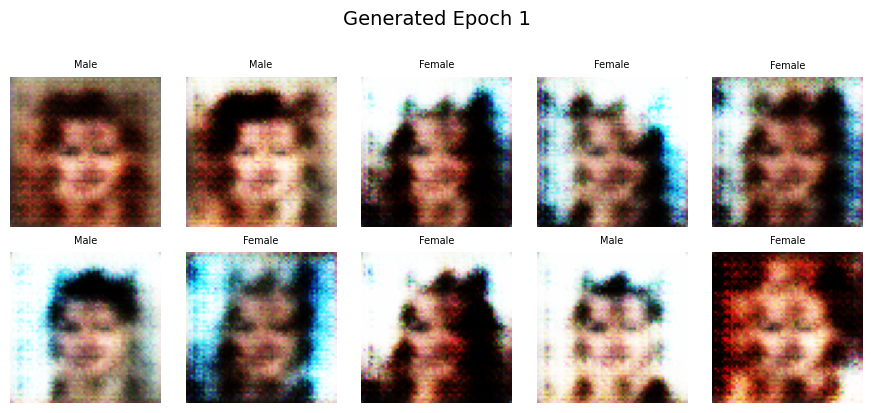

In [28]:
output_dir = "generated_images"
os.makedirs(output_dir, exist_ok=True)

gen_losses = []
dis_losses = []

gen.train()
dis.train()

for epoch in range(1, EPOCHS + 1):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}/{EPOCHS}")

    for batch_idx, (real_imgs, attr_labels) in enumerate(progress_bar):
        real_imgs = real_imgs.to(device)
        attr_labels = attr_labels.to(device)
        batch_size = real_imgs.size(0)

        # max log(D(x|y)) + log(1 - D(G(z|y)))
        dis.zero_grad()
        real_targets = torch.full((batch_size,), real_y, device=device, dtype=torch.float)
        disc_real_output = dis(real_imgs, attr_labels)
        loss_real = loss_BCE(disc_real_output, real_targets)
        loss_real.backward()
        D_x = disc_real_output.mean().item()
        noise = torch.randn(batch_size, Z_DIM, device=device).view(batch_size, Z_DIM, 1, 1)
        fake_imgs = gen(noise, attr_labels)
        fake_targets = torch.full((batch_size,), fake_y, device=device, dtype=torch.float)
        disc_fake_output = dis(fake_imgs.detach(), attr_labels)
        loss_fake = loss_BCE(disc_fake_output, fake_targets)
        loss_fake.backward()
        D_G_z1 = disc_fake_output.mean().item()
        loss_disc_total = loss_real + loss_fake
        optim_dis.step()


        # max log(D(G(z|y)))
        gen.zero_grad()
        fool_targets = torch.full((batch_size,), real_y, device=device, dtype=torch.float)
        disc_fake_output_for_gen = dis(fake_imgs, attr_labels)
        loss_gen = loss_BCE(disc_fake_output_for_gen, fool_targets)
        loss_gen.backward()
        D_G_z2 = disc_fake_output_for_gen.mean().item()
        optim_gen.step()
        gen_losses.append(loss_gen.item())
        dis_losses.append(loss_disc_total.item())


        progress_bar.set_postfix({
            "G_loss": f"{loss_gen.item():.3f}",
            "D_loss": f"{loss_disc_total.item():.3f}",
            "D(x)": f"{D_x:.3f}",
            "D(G(z))": f"{D_G_z2:.3f}"
        })


    # Save generated samples to disk to create a GIF
    save_path = os.path.join(output_dir, f"epoch_num_{epoch}.png")
    show_generated_images_from_sample(gen, sample_noise, attributes=sample_conditions,
                                      attribute_names=attributes, epoch=epoch,
                                      save_path=save_path, device=device)



# Result

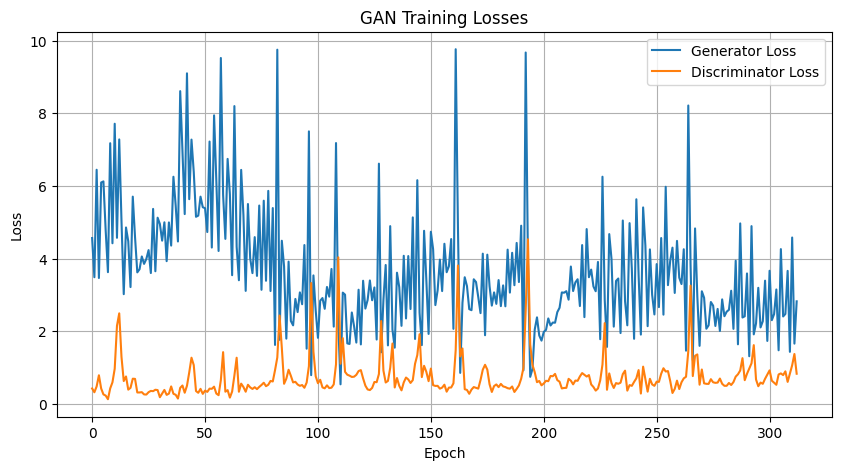

In [29]:
def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_losses(gen_losses, dis_losses)

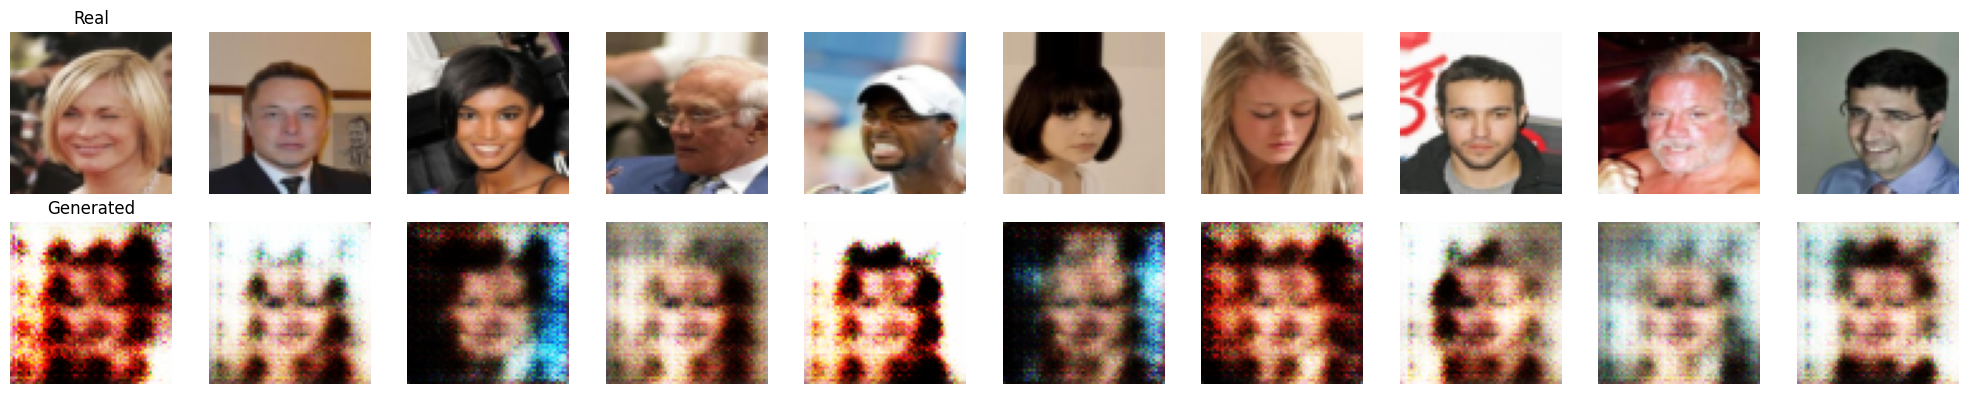

In [30]:
def real_vs_fake(train_loader, generator, noise_dim, n_images, device):
    generator.eval()

    # Get a batch of real images and attributes
    real_batch = next(iter(train_loader))
    real_images, real_attrs = real_batch[0][:n_images], real_batch[1][:n_images]
    real_images = real_images.to(device)
    real_attrs = real_attrs.to(device)

    # Generate fake images conditioned on real attributes
    with torch.no_grad():
        noise = torch.randn(n_images, noise_dim).to(device).view(n_images, noise_dim, 1, 1)
        fake_images = generator(noise, real_attrs)

    # Denormalize from [-1,1] to [0,1]
    real_images = (real_images + 1) / 2
    fake_images = (fake_images + 1) / 2

    # Plot
    fig, axes = plt.subplots(2, n_images, figsize=(n_images * 2, 4))

    for i in range(n_images):
        # Real image
        img_real = real_images[i].cpu().permute(1, 2, 0).numpy()
        axes[0, i].imshow(img_real)
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title("Real")

        # Fake image
        img_fake = fake_images[i].cpu().permute(1, 2, 0).numpy()
        axes[1, i].imshow(img_fake)
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title("Generated")

    plt.tight_layout()
    plt.show()

real_vs_fake(dataloader, gen, noise_dim=Z_DIM, n_images=10, device=device)


In [ ]:
gif_size = (500, 500)

def extract_epoch_num(path):
    match = re.search(r"epoch_num_(\d+)", os.path.basename(path))
    return int(match.group(1)) if match else -1

image_paths = sorted(glob.glob("generated_images/epoch_num_*.png"), key=extract_epoch_num)

images = []

for path in image_paths:
    img = Image.open(path).convert("RGB")
    img = img.resize(gif_size, resample=Image.BILINEAR)
    images.append(np.array(img))

imageio.mimsave("generated_progress.gif", images, fps=5)
